## This notebook is designed to pratice with both geopandas and census data.  This is a simple spatial exploratory analysis of census data. The goal is to assess wheather the location of the [linkNYC](https://www.link.nyc/) access points is optimal to guarantee a more "democratic" access to the internet.

## THE CENSUS: 
make sure you do the assigned reading about the census. Census data are a national trasure! The census is a survey  designed to collect data on every person that lives in the USA every 10 years. The Census Bureau collects data, designes aggregation areas (the census blocks and tracts for example, which are designed for maximal homogeneity across all features). However, the Census Bureau does not only collect and aggregate data every 10 years, it also collects the America Community Survey every 5 years, and some more restricted survey on an annual bases. The 1 year survey data is what we will use: https://www.census.gov/services/index.html


In [71]:
import sys
# !{sys.executable} -m pip install choroplethNYC
import os
import sys
import io
import numpy as np
import pandas as pd
import geopandas as gpd
import urllib
from matplotlib import pyplot as plt
from fiona.crs import from_epsg
import requests
import json
import choroplethNYC as cp
import pylab as pl

import pysal as ps
%matplotlib inline

In [5]:
os.environ['PUIDATA']='%s/PUIdata'%os.getenv('HOME')
os.getenv('PUIDATA')

'/nfshome/sl4729/PUIdata'

# 1. PUMA : Public Use Microdata Area
Census geographies that are not specific political entities (i.e. states, counties etc) are designed for homogeneity so that aggregating the data over the whole area will leat to an estimat (mean or median for example) with minimal variance. Among these geographies are the _census tracts_, _census blocks_, and _Public Use Microdata Areas (PUMAs)_. PUMAs are geographical areas designed to aggregate census data. Each PUMA contains at least 100,000 people. PUMAs do not overlap, and are contained within a single state. 

## 1.1 download the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data

download it as a shape file. When you download a shapefile you actually download a zipped folder which contains the shape file and other files that are necessary to read the shape file in. You can do that with the urllib library in python 3 with the function 

        urllib.request.urlretrieve(url, "file.gz")

then unpack the data into your PUIdata directory, then read it in with geopandas, reading in the shape file with the function 

        geopandas.GeoDataFrame.from_file(filename)

PUMAs were first created for the 1990 Census. PUMAs are identified by a specific 4 numbers id. In the shapefile foung at data.cityofnewyork.us the id is named "puma" and it is in fact a 4 digits number. You can read it in as an integer (although of course it is a categorical variable inherently!). Often the PUMA id is found in conjunction with the 3 numbers state id, leading to a 7 numbers identification. The id for the State of NY is 036. See this link for more: https://www.census.gov/geo/reference/geoidentifiers.html


In [6]:
url='https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
urllib.request.urlretrieve(url, "file.gz")

('file.gz', <http.client.HTTPMessage at 0x7fc7f7b7ddd8>)

In [7]:
!mv file.gz $PUIDATA
!unzip $PUIDATA/file.gz -d $PUIDATA

Archive:  /nfshome/sl4729/PUIdata/file.gz
  inflating: /nfshome/sl4729/PUIdata/geo_export_337169ba-ffe6-40d6-a49a-4ac7829bee28.dbf  
  inflating: /nfshome/sl4729/PUIdata/geo_export_337169ba-ffe6-40d6-a49a-4ac7829bee28.shp  
  inflating: /nfshome/sl4729/PUIdata/geo_export_337169ba-ffe6-40d6-a49a-4ac7829bee28.shx  
  inflating: /nfshome/sl4729/PUIdata/geo_export_337169ba-ffe6-40d6-a49a-4ac7829bee28.prj  


In [8]:
pumashp=gpd.read_file(os.getenv('PUIDATA') + '/' + 'geo_export_35acaf2c-4f5b-4b70-a7fc-6e2c91998b16.shp')
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [9]:
pumashp.crs

{'init': 'epsg:4326'}

## 1.2  plot the PUMA NYC regions

you can use the geopandas function plot. 
What is the appropriate plot to just show the shape of the PUMA regions? A choropleth could be ok, but it is better to just draw the contours of the region, since we do not want to highlight some regions over others by color choices. 

(Note: a while ago I wrote a quick function that plots choropleths and maps of NYC specifically putting legends and colorbars in the empty spaces taking advantage of the shape of the city and you are welcome to use it: https://github.com/fedhere/choroplethNYC. BUT YOU DO NOT HAVE TO)

If you want to learn how to install a package from within the notebook look here https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

Your map should look someting like:

Text(0.5,1,'PUMA NYC regions')

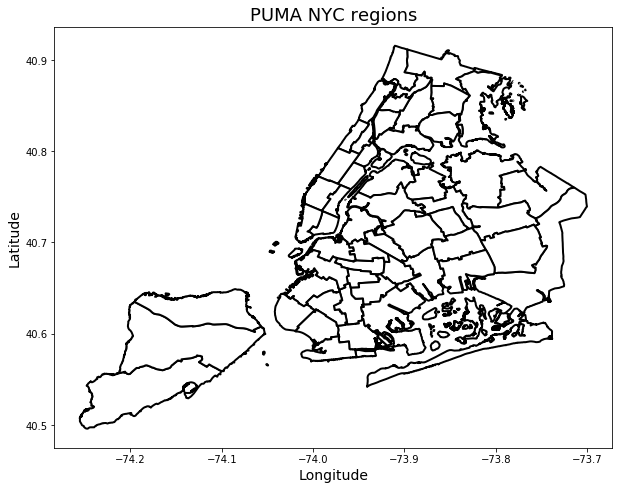

In [10]:
# using the built in plot function as pumashp.plot(pumashp....)
# using a choroplethNYC function that FBB wrote
# import choroplethNYC as cp
ax=pumashp.plot(figsize=(10,10),color="white", edgecolor="black", lw=2)
ax.set_xlabel('Longitude',fontsize = 14)
ax.set_ylabel('Latitude',fontsize = 14)
ax.set_title('PUMA NYC regions', fontsize=18)

Figure 1: shows the PUMA NYC regions

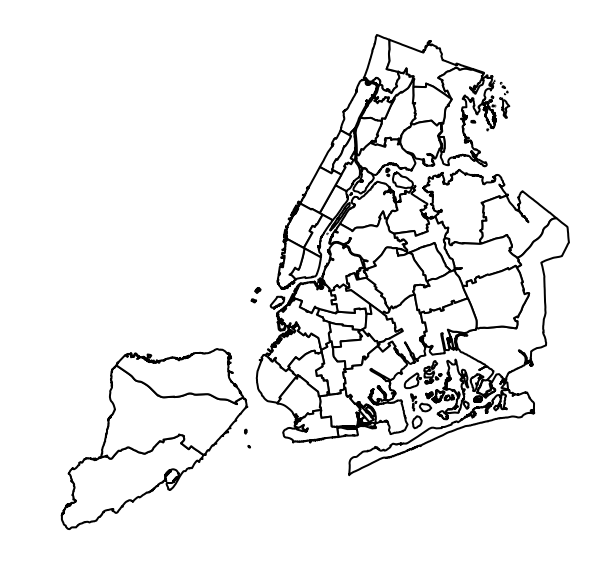

In [11]:
import choroplethNYC as cp
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);

Figure 2: PUMA NYC regions

# 2. American Fact Finder data on percentage of houses with broadband internet access

Download the table of data from 2016 for NYC: you want to obtain data on broadband access (percentage of households with broadband access) at the PUMA (Public Use Microdata Area) geographical area level. 

This may be tricky. But familiarizing with Census and American Commjunity Survey data is super important for urban science. Here you should use the API, but you should also practice interacting with the website: 

You  should read the datta in thgouth the API but also download the data manually and compare the two datasets.

## 2.1 Get data with American Fact Finder (AFF) API: 
you can request an API key, although I think it is not necessary for this search (but it is good to practice). Obtain a key and save it into a python file. DO NOT UPLOAD THE FILE CONTAINING THE API KEY TO GITHUB. Keep your API keys private. 

In [12]:
#reading in my api key saved in censusAPI.py as
myAPI = '3faef0ee862b62bac66feaea8259fafe4bf2d774'
#from censusAPI import myAPI

If you need help with the API you can ask questions in this [Gitter channel](https://gitter.im/uscensusbureau/general) (I did myself to design this homework!) 
The internet subscription by household is data surveyd annually. You can find out what are the features that you can query through the API for the annually surveyed data at this url: https://api.census.gov/data/2016/acs/acs1/variables.json

read it in as a jason file - you can do it with pandas (but it is slow). You can do it as I do below with the request package

In [13]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [14]:
aff1y

{'variables': {'B28008_007E': {'attributes': 'B28008_007M,B28008_007EA',
   'concept': 'PRESENCE OF A COMPUTER AND TYPE OF INTERNET SUBSCRIPTION IN HOUSEHOLD',
   'group': 'B28008',
   'label': 'Estimate!!Total!!Has a computer!!With a broadband subscription!!With a fixed broadband Internet subscription!!Without a cellular data plan',
   'limit': 0,
   'predicateType': 'int'},
  'C08511_024E': {'attributes': 'C08511_024M,C08511_024EA',
   'concept': 'MEANS OF TRANSPORTATION TO WORK BY CITIZENSHIP STATUS FOR WORKPLACE GEOGRAPHY',
   'group': 'C08511',
   'label': 'Estimate!!Total!!Taxicab, motorcycle, bicycle, walked, or other means!!Foreign born!!Naturalized U.S. citizen',
   'limit': 0,
   'predicateType': 'int'},
  'B19131_038E': {'attributes': 'B19131_038M,B19131_038EA',
   'concept': 'FAMILY TYPE BY PRESENCE OF OWN CHILDREN UNDER 18 YEARS BY FAMILY INCOME IN THE PAST 12 MONTHS (IN 2016 INFLATION-ADJUSTED DOLLARS)',
   'group': 'B19131',
   'label': 'Estimate!!Total!!Other family!!Ma

In [15]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))
#Python2
#affkeys = np.array(aff1y['variables'].keys())

You need two features: **total number of households**, and **number of households with broadband access**

Broadband access is one of the B28002 keys. However there are many of those! Each variable has several observations associated to it: B28002 is all internet access data (broadband, dial up, none, ...), and for each of those you have the estimate (count, mean, median, percentage...), the margin of errors, and annotations. Those are identified by an appendix that begins with "\_". Look carefully at the line of code below and its output. I am creating a list that contains the keys of the dictionary I created from the json file for all B28002 observations  (rows that start with "B28002") that include the word "Broadband" in the description.

The syntax is a lost comprehension:

        as = \[a for a in listOfAs\] 

is simply a compact way to write

        as = \[\]
        for a in listOfAs:
            as.append(a)
            
with an if statement tha selects broadband         

In [16]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription')]

chose the appropriate variable and extract the relevant data: below I select the variable containing the number of household per PUMA. The "all" variable, which tells you what is the total number of units queried (households here) is generally stored in the \_001 variable (B28002_001 in this case). "E" stands for *estimate*. M stands for *margin of error*, EA *estimate annotations*, MA *margin of error annotations*. You want the estimate for this exercise. 

In [17]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

Similarly, choose the fractions of houses with any "With an Internet subscription!!Broadband of any type"

In [18]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

Now that you have the variable names use them to extract the relevant data with the ACS API. 

The API url is as follows:

root: https://api.census.gov/data/2016/acs/acs1

action: get=\[variable Name\],NAME

geometry: for=\[geometry\]:\[desired geometry values\]in=\[larger geometry\]:\[desired larger geometry values\]

API key: key:\[api key\]

the URL is constructed as root?action&geometry&key

Note that it took me a long time to figure out how to request the right geometry: in the url I write below the geometry is "public%20use%20microdata%20area" where %20 is the character for ' ' (space) in a url, and ":\*" means all PUMAS

state:36 is New York State

In [19]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [20]:
#getting the first row of the table: the total number of households
url001 = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp001 = requests.request('GET', url001).content
pumaPP = pd.read_csv(io.StringIO(resp001.decode('utf-8').replace('[','').replace(']','')))


In [21]:
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [22]:
puma0104=pumaBB.merge(pumaPP)
puma0104.head(20)

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146
5,32221,"Otsego, Schoharie, Oneida (South) & Herkimer (...",36,403,NaN,42081
6,41386,"Jefferson & Lewis Counties PUMA, New York",36,500,NaN,50860
7,37692,"Oswego County PUMA, New York",36,600,NaN,44633
8,37719,"Onondaga County (Central)--Syracuse City PUMA,...",36,701,NaN,56295
9,40309,"Onondaga County (North) PUMA, New York",36,702,NaN,47988


In [23]:
puma0104['pcBB']=puma0104['B28002_004E']/puma0104['B28002_001E']*100
puma0104.columns

Index(['B28002_004E', 'NAME', 'state', 'public use microdata area',
       'Unnamed: 4', 'B28002_001E', 'pcBB'],
      dtype='object')

In [24]:
puma0104.drop(['Unnamed: 4'],axis=1,inplace=True)
puma0104.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

Manually you can download the GCT Geographic Comparison Tables. Download the GCT table that contains the percentage of households in each PUMA with broadband internet subscription as follows:

https://factfinder.census.gov/ -> Advanced Search -> Show me all 

    - Topics: Product Type -> Geography Comparison Table 
    
select the PERCENT OF HOUSEHOLDS WITH A BROADBAND INTERNET SUBSCRIPTION  at our geography granularity (PUMA) and click Download below. This will generate the table on the fly and you can click again on Download.

Move the file into the PUIdata directory, unzip it and load it with pandas.
    
Your table shold be labeled as: GCT2801	

One more hurdle: you need to move this data to jupyterhub/compute, and the link is not something you can copy and paste!
Two solutions:

-easier but less preferible: upload the table you downloaded locally to github AWS, or else where, and download it from compute

-otherwise, learn how to do it with sftp from your local terminal: these are the steps

1. ON YOUR LOCAL MACHINE where you downloaded the table (which was downloaded as aff_download.zip for me in my ~/Downloads folder) type the following *sftp* command
        
        fbianco@Federicas-MacBook-Air:~$ sftp fbianco@staging.cusp.nyu.edu
    
2. Input your password
            
        Password: 
        Connected to staging.cusp.nyu.edu.

   This should open an sftp promopt (you should see sftp> at the beginning of the line). Go to the PUI directory (for me /home/fbianco/PUIdata)
    
        sftp> cd /home/fbianco/PUIdata             
        
3. Use the sftp command _put_ to copy the file from the local to the remote machine to compute, making sure you use the full path (unless the file was downloaded in your local directory in the local machine)
    
        sftp> put /Users/fbianco/Downloads/aff_download.zip
        
You should see:

            Uploading /Users/fbianco/Downloads/aff_download.zip to ....

And the file can be unzipped and read into your code with pandas. I leave the read in line below for your convenience, those are the only variables you need.

In [25]:
!unzip $PUIDATA/aff_download.zip -d $PUIDATA

Archive:  /nfshome/sl4729/PUIdata/aff_download.zip
replace /nfshome/sl4729/PUIdata/ACS_16_1YR_GCT2801.ST50_with_ann.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [27]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


notice 2 things:
    - that the Target Geo Id2: GCT_STUB.target-geo-id2 is a 7 digits number. See my comment above about it. 
    - that there is a weird double header. You can deal with it in one of 2 ways: either reread the file in skipping one row and using the second row as header, or remove that row (for example with bbpc.drop(0, inplace=True)) but also then you should check the *type* of your GCT_STUB.target-geo-id2 feature! The fact that pandas had to read in a column with nombers and characters forced it to read it as a string, and you need to convert it (.astype(int)) to merge it easily with the API acquired data.
    
In the API dataframe the PUMA id was a 4 digit number. If you have them both as integers and you remove the initial three digits (for example by subtracting 360000 from each value wich you can do as bbpc["gid"] = bbpc.gid - 3600000 then you can merge on the puma id 

In [28]:
bbpc.drop(0, inplace=True)
columns=['gid','HC01','HC02']
bbpc.columns=columns

In [29]:
bbpc.head()

,gid,HC01,HC02
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8
5,0100302,81.9,2.9


In [30]:
type(bbpc.gid[1])

str

In [31]:
#bbpc.gid=bbpc.gid.astype(str)

In [32]:
#bbpc["gid"] = bbpc.gid - 3600000
bbpc["gid"]=bbpc.gid.str[-4:]

In [33]:
bbpc.head()

,gid,HC01,HC02
1,01,74.7,0.5
2,0100,70.9,2.5
3,0200,80.5,2.7
4,0301,87.0,2.8
5,0302,81.9,2.9


In [34]:
bbpc.gid=bbpc.gid.astype(int)
bbpc.HC01=bbpc.HC01.astype(float)
bbpc.HC02=bbpc.HC02.astype(float)

## check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

In [35]:
diff_ = puma0104.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,HC01,diff
count,873.000000,873.000000,873.000000
mean,81.228478,80.001604,6.456194
std,5.799460,8.449635,6.662736
min,54.932945,47.200000,0.000178
25%,77.812999,74.900000,1.127605
50%,81.246002,80.500000,4.857322
75%,84.808653,86.300000,9.587001
max,93.404143,96.900000,41.017633


In [36]:
diff_.head()

,pcBB,HC01,diff
0,80.552879,70.9,9.652879
1,80.552879,94.3,13.747121
2,80.552879,58.7,21.852879
3,80.552879,80.7,0.147121
4,80.552879,78.3,2.252879


the maximum difference should only be a few percent

# 3 Plot a choropleth of NYC broadband access 
## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [37]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [38]:
type(pumashp.puma[1])

str

In [39]:
pumashp.puma=pumashp.puma.astype(int)

In [40]:
puma0104.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


In [41]:
pumashp1 = pumashp.merge(puma0104,left_on='puma', right_on='public use microdata area')
pumashp1.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618


(<matplotlib.figure.Figure at 0x7fc7eefbcc88>,
 <matplotlib.colorbar.Colorbar at 0x7fc7eef1a7b8>)

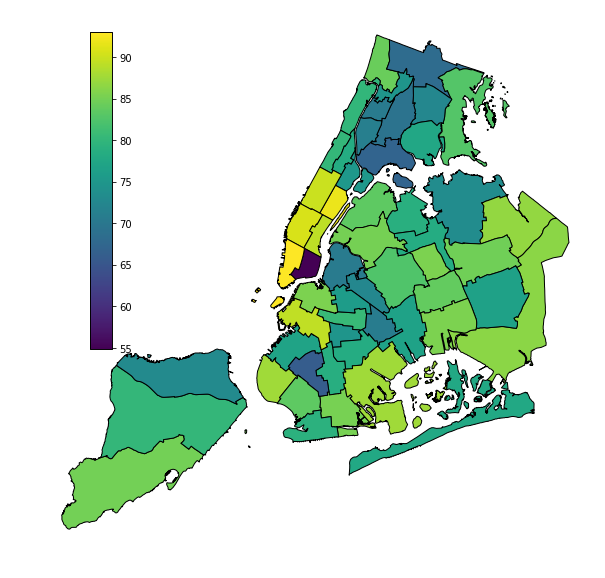

In [42]:
cp.choroplethNYC(pumashp1, column='pcBB', edgecolor="Black")

Figure 3: choropleth of NYC broadband access

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

acquire the linkNYC locations and prepare them into a dataframe
read it in from the HW7_fb55 folder in :
https://github.com/fedhere/PUI2018_fb55

Notice that you can also get a linkNYC locations shapefile from NYC open data, as I did to generate this, but I want you do to do some extra coordinates gymnastics for practice so use the one I provide.

In [43]:
url='https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv'
linkNYC=pd.read_csv(url)

In [44]:
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [45]:
linkNYC.drop(['Unnamed: 0'],axis=1,inplace=True)

In [46]:
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [47]:
linkNYC.shape

(1414, 4)

In [48]:
import shapely
# combine lat and lon to one column
linkNYC['lonlat']=list(zip(linkNYC.longitude,linkNYC.latitude))
# Create Point Geometry for based on lonlat column
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


## combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame _linkNYC_ and set native coordinates  frame to lat/lon as you did in the lab
    linkNYC.crs = ...

In [49]:
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [50]:
linkNYC = gpd.GeoDataFrame(linkNYC)

In [51]:
linkNYC.crs = {'init': 'epsg:4326'}
# naec = '+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'
# linkNYC.to_crs(naec).plot(figsize=(10,10))

# plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in *5 equal intervals*

I have also color coded the station by how long ago they have been installed, using the date datetime variable

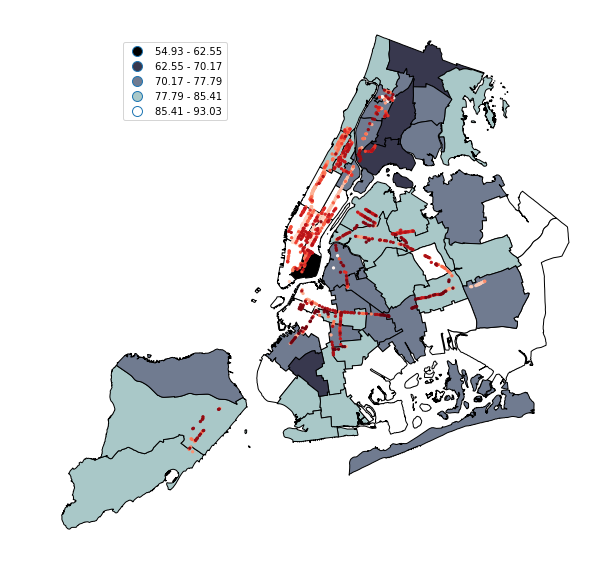

In [52]:

fig,ax,bar = cp.choroplethNYC(pumashp1, scheme="Equal_interval", k=5, column="pcBB", cmap="bone", edgecolor="black", cb=False)
linkNYC.plot(c='date_link_',cmap='Reds',ax=ax,markersize=5,legend=True)

Figure 4: location of the linkNYC stations on top of a choropleth of broadband access

In [53]:
cp.choroplethNYC?

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

the ACS population by  variable is B00001_001E, and of course your geometry is PUMA, _public%20use%20microdata%20area:*_, as before

In [54]:
keyTotalP = 'B00001_001E'
aff1y['variables'][keyTotalP]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [55]:
urlTotalP = "https://api.census.gov/data/2016/acs/acs1?get=" + keyTotalP  +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
respTP = requests.request('GET', urlTotalP).content
pumaPop = pd.read_csv(io.StringIO(respTP.decode('utf-8').replace('[','').replace(']','')))


In [56]:
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [57]:
pumaPop = pumaPop[['B00001_001E', 'public use microdata area']]
pumaPop.head()

,B00001_001E,public use microdata area
0,3075,100
1,4356,200
2,2736,300
3,2722,401
4,2874,402


In [58]:
pumashp2=pumashp1.merge(pumaPop,on = 'public use microdata area')
pumashp2.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB,B00001_001E
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618,2515


## 5.2 find the number of station per 100 people per PUMA
**Important** you can do this with an sjoin(). But sjoin() should not be used with lat/lon coordinates cause they are **not "flat coordinates"**. Since spattial joins are done in cartesian geometry the only coordinate systems suitable to spatial joins are flat coordinate plane systems, which in the NYC area is 2263. So before you proceed to the sjoin you have to convert both pumashp and linkNYC to 2263 (for example with GeoDataFrame method .to_crs(epsg=...) )


(A note: You can also do this by hand by asking for each point if it is in any of the regions, for example in a for loop. But that is escruciatingly slow, unless you get smart about your requests (for example for a given PUMA not asking if the coordinates of a point are very different from the center of a PUMA). With the new version of geopandas this is not needed, cause the sjoin is fast, but with the older versions this was sometimes better) )

convert coordinates for pumashp and linkNYC

In [59]:
pumashp2.to_crs(epsg=2263)
linkNYC.to_crs(epsg=2263)
print(pumashp2.crs,linkNYC.crs)

{'init': 'epsg:4326'} {'init': 'epsg:4326'}


In [60]:
pumashp2.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB,B00001_001E
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618,2515


In [61]:
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [62]:
linkpp = gpd.sjoin(pumashp2,linkNYC).groupby('puma').size().to_frame()
linkpp.reset_index(inplace=True)
linkpp.columns=['puma','link_site']
linkpp.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA

finally merge back into the pumashp. Make sure you use the correct scheme for merging: you want to have _all_ the PUMAs, not only the ones that have linkNYC in them in the final geoDF

In [63]:
pumashplc = pumashp2.merge(linkpp, on='puma',how='outer').fillna(0)
pumashplc.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB,B00001_001E,link_site
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,1.0
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959,0.0
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305,0.0
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882,0.0
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618,2515,3.0


In [89]:
pumashplc['linkNYCp100p'] = (pumashplc['link_site'] / pumashplc['B00001_001E']) * 100
pumashplc["linkNYCp100p"].describe()

count    55.000000
mean      1.565892
std       2.933074
min       0.000000
25%       0.000000
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

# at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people  in 10 equal intervals


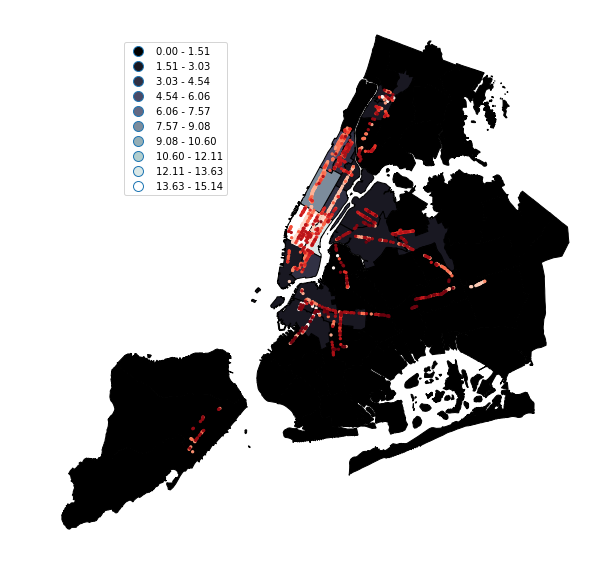

In [65]:
fig,ax,bar = cp.choroplethNYC(pumashplc, scheme="Equal_interval", k=10, column="linkNYCp100p", cmap="bone", edgecolor="black", cb=False)
linkNYC.plot(c='date_link_',cmap='Reds',ax=ax,markersize=5,legend=True)

Figure 5:linkNYC locations on top of a choropleth of number of stations per 100 people 

# Extra credit 1: 
How would you enhance the visibility of this map? you are working with numbers that are mostly very low, and reside near each other, and them have a few much higher value points. Notice that here the high values are interesting though and should not be thrown away!

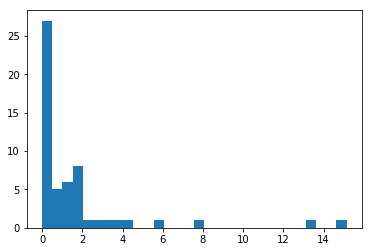

In [87]:
pl.hist(pumashplc["linkNYCp100p"], bins=30);

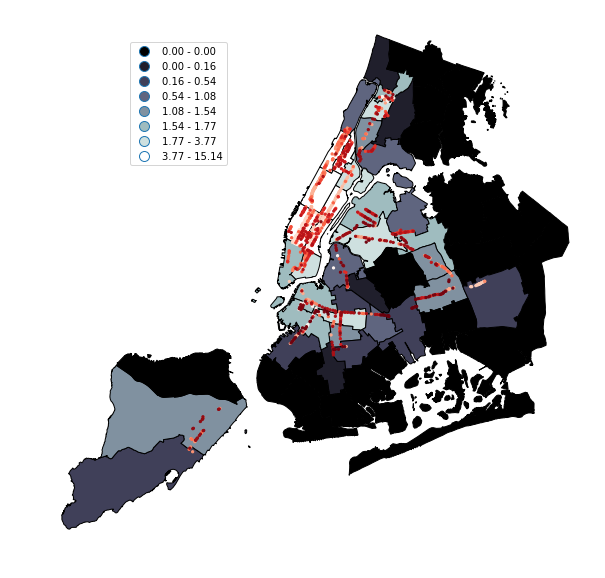

In [68]:
fig,ax,bar = cp.choroplethNYC(pumashplc, scheme="Quantiles", k=10, column="linkNYCp100p", cmap="bone", edgecolor="black", cb=False)
linkNYC.plot(c='date_link_',cmap='Reds',ax=ax,markersize=5,legend=True)

Figure 5:linkNYC locations on top of a choropleth of number of stations per 100 people, Quantiles

## Extra Credit 2:
plot Spatial Lag Deciles that describe the impact of linkNYC in providing access where needed. You can follow what you did in the lab, but you need to create a metric based on the data you have tha measures the impact of linkNYC


In [74]:
%mkdir Output

In [81]:
path='Output/pumashplc.shp'
pumashplc.to_file(path)

In [82]:
qW_CT=ps.queen_from_shapefile(path)

In [84]:
Wmatrix, ids = qW_CT.full()
Wmatrix

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [85]:
qW_CT.transform = 'r'

In [92]:
spatialLag=ps.lag_spatial(qW_CT,pumashplc['linkNYCp100p'])

In [93]:
spatialLagQ10 = ps.Quantiles(spatialLag, k=10)
spatialLagQ10

              Quantiles              
 
Lower          Upper            Count
        x[i] <= 0.017               6
0.017 < x[i] <= 0.211               5
0.211 < x[i] <= 0.463               6
0.463 < x[i] <= 0.578               5
0.578 < x[i] <= 0.788               6
0.788 < x[i] <= 0.989               5
0.989 < x[i] <= 1.193               6
1.193 < x[i] <= 2.997               5
2.997 < x[i] <= 5.159               5
5.159 < x[i] <= 9.704               6

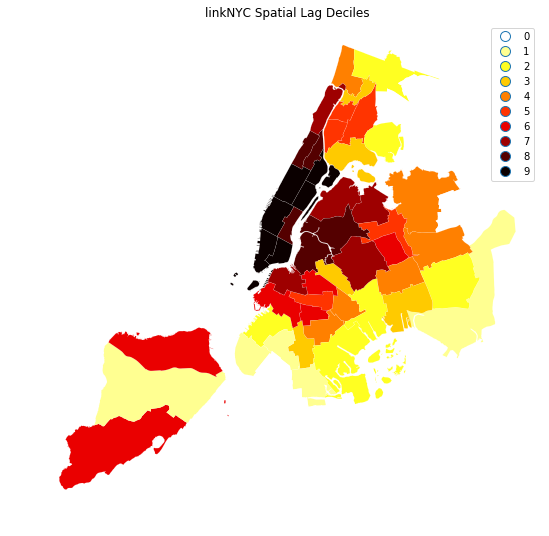

In [96]:
f, ax = plt.subplots(figsize=(9, 9))
pumashplc.assign(cl=spatialLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("linkNYC Spatial Lag Deciles");

Figure 6:  Spatial Lag Deciles that describe the impact of linkNYC 

this is whay I came up with, and needs not be the same for you. But properly describe what you obtain


Note: To find the table you extracted through the API manually you could

https://factfinder.census.gov/ -> Advanced Search -> Show me all 
    
    - Topics: Housing -> Physical Characteristics -> Internet Access
    - Geographies -> all geography types -> Public Use Microdata Areas (755)
                     -> Select a State: New York -> All Pubic Use Microdaa Areas within New York
                     -> Add Your Selection
    - Years -> 2016